# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182254 entries, 0 to 182253
Data columns (total 78 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   filename             182254 non-null  object 
 1   tempo                182254 non-null  float64
 2   total_beats          182254 non-null  int64  
 3   average_beats        182254 non-null  float64
 4   chroma_stft_mean     182254 non-null  float64
 5   chroma_stft_var      182254 non-null  float64
 6   chroma_cq_mean       182254 non-null  float64
 7   chroma_cq_var        182254 non-null  float64
 8   chroma_cens_mean     182254 non-null  float64
 9   chroma_cens_var      182254 non-null  float64
 10  melspectrogram_mean  182254 non-null  float64
 11  melspectrogram_var   182254 non-null  float64
 12  mfcc_mean            182254 non-null  float64
 13  mfcc_var             182254 non-null  float64
 14  mfcc_delta_mean      182254 non-null  float64
 15  mfcc_delta_var   

In [5]:
df['label'] = df['filename'].str.split('_').str[-2]

In [6]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [7]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [8]:
print(X_train_scaled)

[[-0.98188845 -0.66652426 -0.50251035 ... -0.71452695  1.13479713
  -0.96121638]
 [ 1.8977701   0.30288644  0.20423714 ...  0.09663193  0.53793319
  -0.39115457]
 [ 0.22756814 -0.60304792 -0.74124732 ...  0.55786375  0.85330671
   0.52734208]
 ...
 [-0.98188845 -0.71222723 -0.9670796  ...  2.79995053 -0.4349303
   2.32059267]
 [-0.12671712  2.07286078  1.99583986 ... -0.43870178 -0.55521336
  -0.41269647]
 [-0.12671712  1.05927054  1.36123826 ...  0.40455881 -1.59415278
  -0.4228941 ]]


Define the network parameters

In [9]:
num_neurons = 128
learning_rate = 0.001
batch_size = 256
no_epochs = 100

In [10]:
model = Sequential([Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(num_neurons, activation ='relu'),
                    Dropout(0.2), Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(1, activation='sigmoid')])


In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss= 'binary_crossentropy', optimizer = "adam", metrics= ['accuracy']) #Default learning rate for adam algo is 0.001

In [12]:
history = {}
history['model'] = model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 2,
                            batch_size = batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
499/499 - 4s - loss: 0.6896 - accuracy: 0.5363 - val_loss: 0.6846 - val_accuracy: 0.5518 - 4s/epoch - 8ms/step
Epoch 2/100
499/499 - 2s - loss: 0.6835 - accuracy: 0.5542 - val_loss: 0.6813 - val_accuracy: 0.5570 - 2s/epoch - 4ms/step
Epoch 3/100
499/499 - 2s - loss: 0.6801 - accuracy: 0.5597 - val_loss: 0.6799 - val_accuracy: 0.5634 - 2s/epoch - 4ms/step
Epoch 4/100
499/499 - 2s - loss: 0.6769 - accuracy: 0.5668 - val_loss: 0.6762 - val_accuracy: 0.5682 - 2s/epoch - 4ms/step
Epoch 5/100
499/499 - 2s - loss: 0.6741 - accuracy: 0.5715 - val_loss: 0.6729 - val_accuracy: 0.5740 - 2s/epoch - 4ms/step
Epoch 6/100
499/499 - 2s - loss: 0.6706 - accuracy: 0.5791 - val_loss: 0.6704 - val_accuracy: 0.5775 - 2s/epoch - 4ms/step
Epoch 7/100
499/499 - 2s - loss: 0.6672 - accuracy: 0.5849 - val_loss: 0.6671 - val_accuracy: 0.5880 - 2s/epoch - 4ms/step
Epoch 8/100
499/499 - 2s - loss: 0.6639 - accuracy: 0.5901 - val_loss: 0.6634 - val_accuracy: 0.5893 - 2s/epoch - 4ms/step
Epoch 9/100
499/

Evaluate the model

In [13]:
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose = 0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose = 0)

print("Train loss: {}, Train accuracy: {}".format(train_loss, train_acc))
print("Test loss: {}, Test accuracy: {}".format(test_loss, test_acc))

Train loss: 0.5366610288619995, Train accuracy: 0.745259702205658
Test loss: 0.6048303246498108, Test accuracy: 0.6586498618125916


Plotting train and test accuracies and loss against training epochs

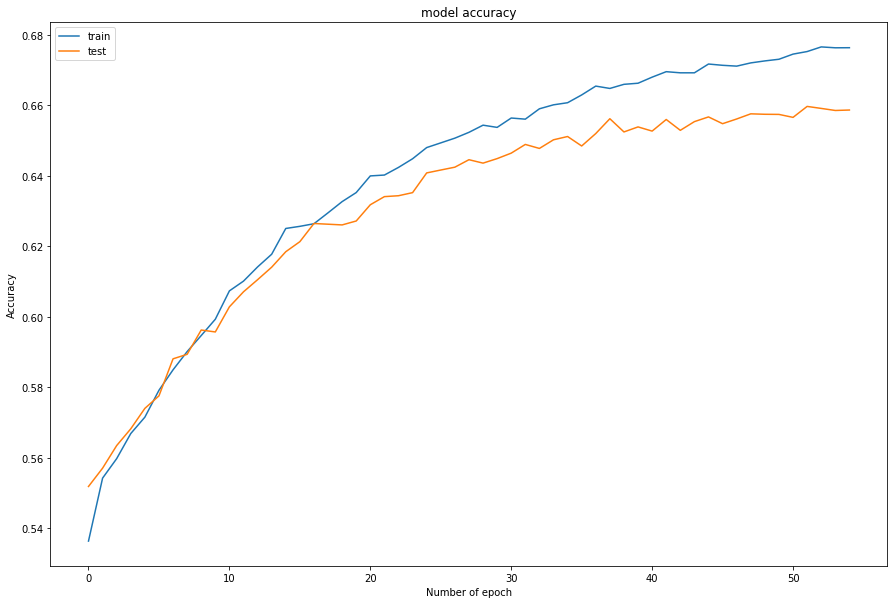

In [14]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['accuracy'])
plt.plot(history['model'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

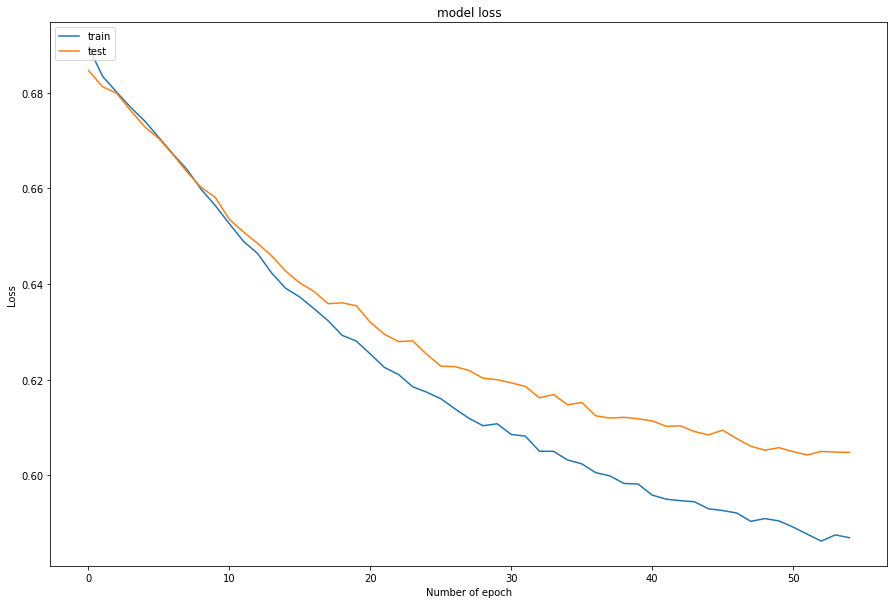

In [15]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['loss'])
plt.plot(history['model'].history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('figures/1a_loss.png')
plt.show()

Answers to 1b

Comments on the line plots: 

Both training and validation accuracies of the model is increasing at a decreasing rate. Initially as the model trains, accuracy of the model rises sharply and its growth would decrease and if there was no early-stopping mechanism, the model might overfit which compromise on the model's accuracy.

Both training and validation loss are decreasing. Loss indicates the error or "how bad" the predictions are against the targeted value. We aim to minimize loss as it indicates robustness of the model.



Why early stopping is required:

Early stopping is required to reduce overfitting without compromising on model accuracy. With the early stopping technique, the model will stop training before it starts to overfit which leads to increase in error and a drop in model's accuracy.


QUESTION 2

In [16]:
from sklearn import datasets
from sklearn.model_selection import KFold

Q2b) Timing callback for every epoch

In [17]:
#TimingCallBack class for Q2b

class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)



In [18]:
no_folds = 5
batch_size_list = [128, 256, 512, 1024]
cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [19]:
def preparing_dataset(df, columns_to_drop):

    data = df.copy()
    label_encoder = preprocessing.LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['label'])

    Y = data['label']
    X = data.drop(columns_to_drop, axis = 1)
    return X,Y

    

In [20]:
Q2_X, Q2_Y = preparing_dataset(df, columns_to_drop=columns_to_drop)

In [21]:
model_acc = {}
model_train_acc = {}
model_loss = {}
Q2_history = {}
time_taken_dict = {}
batch_idx = 0

model_list = ["model_128", "model_256", "model_512", "model_1024"]
model_fold = ["_0", "_1", "_2", "_3" ,"_4"]

for models in model_list:
    fold = 0
    train_acc = []
    val_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q2_X, Q2_Y):
        cb = TimingCallback()
        
        Q2_X_train, Q2_y_train  = Q2_X.iloc[train_idx], Q2_Y.iloc[train_idx]
        Q2_y_train = Q2_y_train.to_numpy()

        Q2_X_test, Q2_y_test = Q2_X.iloc[test_idx], Q2_Y.iloc[test_idx]
        Q2_y_test = Q2_y_test.to_numpy()

        Q2_X_train_scaled, Q2_X_test_scaled = preprocess_dataset(Q2_X_train, Q2_X_test)
        
        Q2_model = Sequential([Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(num_neurons, activation ='relu'),
                        Dropout(0.2), Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q2_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q2_history[models + model_fold[fold]] = Q2_model.fit(Q2_X_train_scaled, Q2_y_train,
                        batch_size = batch_size_list[batch_idx],
                        epochs=no_epochs,
                        verbose=0,
                        use_multiprocessing=True,
                        validation_data=(Q2_X_test_scaled, Q2_y_test), callbacks=[callback, cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(cb.times[-1])
        #print("Time Taken for final epoch " + models + model_fold[fold] + " : {}".format(cb.times[-1]))

        #Validation Accuracy of final epoch of each fold
        val_acc.append(Q2_history[models + model_fold[fold]].history['val_accuracy'][-1])

        #Training Accuracy of final epoch of each fold
        train_acc.append(Q2_history[models + model_fold[fold]].history['accuracy'][-1])
        
        #Val loss of final epoch of each fold
        val_loss.append(Q2_history[models + model_fold[fold]].history['val_loss'][-1])

        print(models +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    batch_idx +=1
    model_acc[models] = val_acc
    model_train_acc[models] = train_acc
    model_loss[models] = val_loss
    time_taken_dict[models]= time_taken_list
    print(models + '* mean accuracy = %g *'% np.mean(val_acc))
    


model_128 fold 0 test accuracy 0.664728
model_128 fold 1 test accuracy 0.675949
model_128 fold 2 test accuracy 0.668349
model_128 fold 3 test accuracy 0.666758
model_128 fold 4 test accuracy 0.677339
model_128* mean accuracy = 0.670625 *
model_256 fold 0 test accuracy 0.666786
model_256 fold 1 test accuracy 0.661628
model_256 fold 2 test accuracy 0.675043
model_256 fold 3 test accuracy 0.675839
model_256 fold 4 test accuracy 0.661481
model_256* mean accuracy = 0.668155 *
model_512 fold 0 test accuracy 0.677183
model_512 fold 1 test accuracy 0.663987
model_512 fold 2 test accuracy 0.674961
model_512 fold 3 test accuracy 0.66909
model_512 fold 4 test accuracy 0.671687
model_512* mean accuracy = 0.671382 *
model_1024 fold 0 test accuracy 0.673946
model_1024 fold 1 test accuracy 0.664042
model_1024 fold 2 test accuracy 0.666292
model_1024 fold 3 test accuracy 0.666813
model_1024 fold 4 test accuracy 0.674047
model_1024* mean accuracy = 0.669028 *


In [22]:
print("Validation Accuracy\n")
for key, value in model_acc.items():
    print(key + ': ', value)

print("\n")

print("Training Accuracy\n")
for key, value in model_train_acc.items():
    print(key + ': ', value)


Validation Accuracy

model_128:  [0.6647279858589172, 0.6759485602378845, 0.6683492660522461, 0.666758120059967, 0.6773388385772705]
model_256:  [0.6667855381965637, 0.6616279482841492, 0.6750432252883911, 0.6758387684822083, 0.661481499671936]
model_512:  [0.6771830916404724, 0.6639872789382935, 0.6749609112739563, 0.6690900325775146, 0.6716872453689575]
model_1024:  [0.6739458441734314, 0.6640421152114868, 0.6662917137145996, 0.6668129563331604, 0.6740466356277466]


Training Accuracy

model_128:  [0.6739710569381714, 0.6804043650627136, 0.6724209785461426, 0.6741631031036377, 0.6863803267478943]
model_256:  [0.6762824058532715, 0.66761314868927, 0.6801162958145142, 0.6790395379066467, 0.6653726696968079]
model_512:  [0.6865016222000122, 0.6686282157897949, 0.6841217279434204, 0.6750066876411438, 0.678266704082489]
model_1024:  [0.6811588406562805, 0.6718654632568359, 0.6723935604095459, 0.6733606457710266, 0.6831019520759583]


In [23]:
for key, value in time_taken_dict.items():
    print(key + ': ', value)

model_128:  [5.23428201675415, 3.4790902137756348, 3.3616676330566406, 3.4193649291992188, 3.6714446544647217]
model_256:  [1.9547934532165527, 1.8473899364471436, 2.2622268199920654, 1.7029776573181152, 1.8602328300476074]
model_512:  [0.851987361907959, 0.9239988327026367, 0.8597221374511719, 0.8500003814697266, 1.0301296710968018]
model_1024:  [0.4652714729309082, 0.46146631240844727, 0.4783508777618408, 0.586390495300293, 0.47437477111816406]


Q2a) Mean Cross-validation accuracies against different batch_sizes

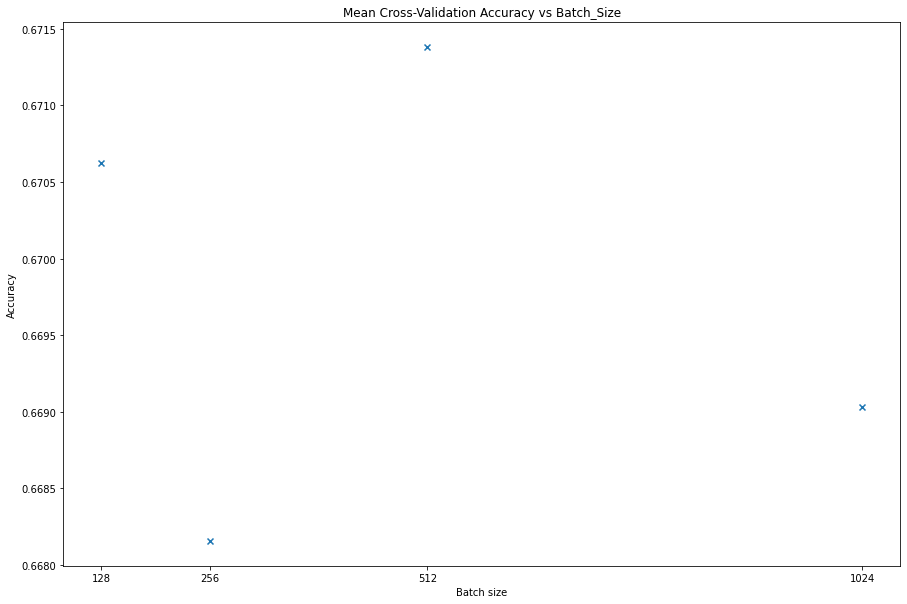

In [24]:
mean_val_acc = []
for key, value in model_acc.items():
    mean_val_acc.append(np.mean(value))

mean_val_loss = []
for key, value in model_loss.items():
    mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_val_acc, marker = 'x')
plt.title('Mean Cross-Validation Accuracy vs Batch_Size')
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()



Q2b) Table of time taken to train the last epoch on each and every batch

In [25]:
mean_time_taken = []
for key, value in time_taken_dict.items():
    mean_time_taken.append(np.mean(value))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[5.23428201675415, 3.4790902137756348, 3.3616676330566406, 3.4193649291992188, 3.6714446544647217], [1.9547934532165527, 1.8473899364471436, 2.2622268199920654, 1.7029776573181152, 1.8602328300476074], [0.851987361907959, 0.9239988327026367, 0.8597221374511719, 0.8500003814697266, 1.0301296710968018], [0.4652714729309082, 0.46146631240844727, 0.4783508777618408, 0.586390495300293, 0.47437477111816406]]


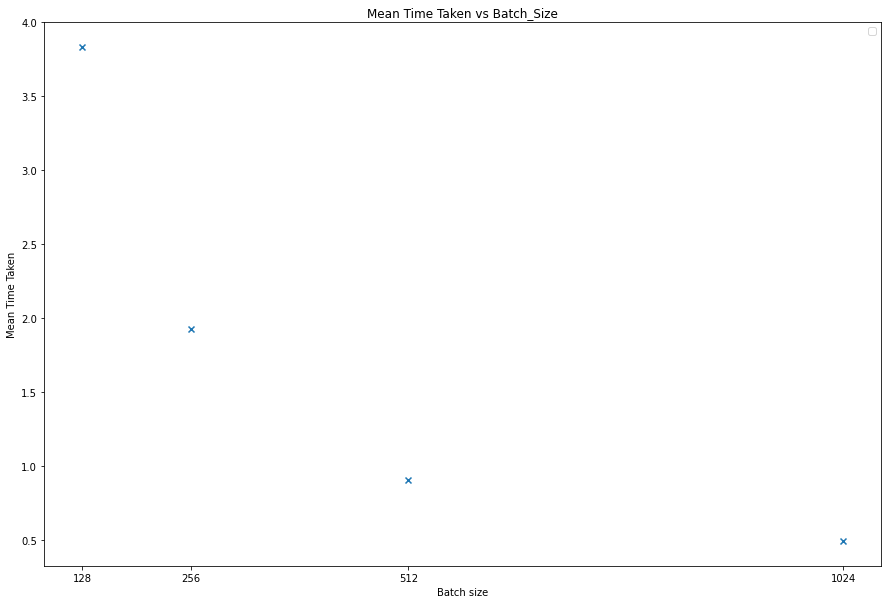

In [26]:
plt_1 = plt.figure(figsize=(15, 10))

print(list(time_taken_dict.values()))

plt.scatter(batch_size_list, mean_time_taken, marker = 'x')
     
plt.title('Mean Time Taken vs Batch_Size')
plt.ylabel('Mean Time Taken')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.legend()
plt.show()

In [27]:
table_df = pd.DataFrame.from_dict(model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
table_df["mean_val_acc"] = mean_val_acc
table_df["mean_val_loss"] = mean_val_loss
table_df["mean_time_taken"] = mean_time_taken
table_df["Batch model"] = model_list
table_df["Batch_size"] = batch_size_list
table_df.set_index('Batch_size', inplace = True)
table_df.head()

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_val_acc,mean_val_loss,mean_time_taken,Batch model
Batch_size,,,,,,,,,
128,0.664728,0.675949,0.668349,0.666758,0.677339,0.670625,0.595815,3.833170,model_128
256,0.666786,0.661628,0.675043,0.675839,0.661481,0.668155,0.598375,1.925524,model_256
512,0.677183,0.663987,0.674961,0.669090,0.671687,0.671382,0.596106,0.903168,model_512
1024,0.673946,0.664042,0.666292,0.666813,0.674047,0.669028,0.597979,0.493171,model_1024


In [28]:
optimal_batch_size = int(table_df['mean_val_acc'].idxmax())
print("Optimal batch size: ", optimal_batch_size)

Optimal batch size:  512


Q2C & Q2D

Optimal Batch Size and why?

The optimal batch size is selected based on the highest mean accuracy that is evaluted through the K-fold cross validation. K-fold cross validation 


As the batch size increases, the training time taken for the final epoch decreases. Holding the number of epochs constant, the total number of gradient descent steps decreases when batch size increases. However, when batch size reach to large enough size, the difference in time taken will be less significant.

Q2E Line Plot

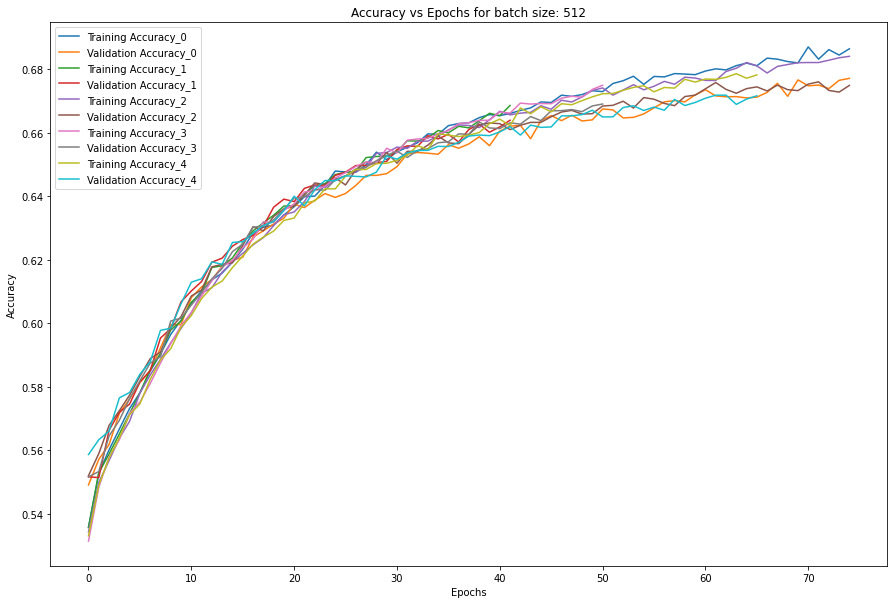

In [29]:
plt_1 = plt.figure(figsize=(15, 10))
optimal_batch_model = str(table_df.loc[optimal_batch_size, "Batch model"])
fold = 0

Q2_legend_list = []

while(fold<no_folds):
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["accuracy"])
    Q2_legend_list.append("Training Accuracy" + model_fold[fold])
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["val_accuracy"])
    Q2_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q2_legend_list)
plt.title('Accuracy vs Epochs for batch size: ' + str(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

QUESTION 3

In [30]:
model_neurons_list = ["model_neurons_64", "model_neurons_128", "model_neurons_256"]
num_neurons_list = [64,128,256]

Q3_X, Q3_Y = preparing_dataset(df, columns_to_drop=columns_to_drop)
Q3_X.head(10)

neurons_idx = 0

In [31]:
Q3_cb = TimingCallback()
Q3_time_taken_dict = {}
Q3_model_acc = {}
Q3_model_train_acc = {}
Q3_model_loss = {}
Q3_history = {}
for model_neurons in model_neurons_list:    
    fold = 0
    val_acc = []
    train_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q3_X, Q3_Y):
        Q3_cb = TimingCallback()
        Q3_X_train, Q3_y_train  = Q3_X.iloc[train_idx], Q3_Y.iloc[train_idx]
        Q3_y_train = Q3_y_train.to_numpy()

        Q3_X_test, Q3_y_test = Q3_X.iloc[test_idx], Q3_Y.iloc[test_idx]
        Q3_y_test = Q3_y_test.to_numpy()

        Q3_X_train_scaled, Q3_X_test_scaled = preprocess_dataset(Q3_X_train, Q3_X_test)
        
        Q3_model = Sequential([Dense(num_neurons_list[neurons_idx], activation='relu'),
                        Dropout(0.2), Dense(num_neurons_list[neurons_idx], activation ='relu'),
                        Dropout(0.2), Dense(num_neurons_list[neurons_idx], activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q3_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q3_history[model_neurons + model_fold[fold]] = Q3_model.fit(Q3_X_train_scaled, Q3_y_train,
                        batch_size = optimal_batch_size,
                        epochs=no_epochs,
                        verbose=0,
                        use_multiprocessing=True,
                        validation_data=(Q3_X_test_scaled, Q3_y_test), callbacks=[callback, Q3_cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(Q3_cb.times[-1])
        #print("Time Taken for final epoch " + model_neurons + model_fold[fold] + ": {}".format(Q3_cb.times[-1]))

        #Val accuracy of final epoch of each fold
        val_acc.append(Q3_history[model_neurons + model_fold[fold]].history['val_accuracy'][-1])

        #Train accuracy of final epoch of each fold
        train_acc.append(Q3_history[model_neurons + model_fold[fold]].history['accuracy'][-1])

        #Val loss of final epoch of each fold
        val_loss.append(Q3_history[model_neurons + model_fold[fold]].history['val_loss'][-1])
        
        print(model_neurons +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    Q3_model_acc[model_neurons] = val_acc
    Q3_model_train_acc[model_neurons] = train_acc
    Q3_time_taken_dict[model_neurons]= time_taken_list
    Q3_model_loss[model_neurons] = val_loss
    print(model_neurons + '* mean accuracy = %g *'% np.mean(val_acc))
    neurons_idx+=1

model_neurons_64 fold 0 test accuracy 0.6089
model_neurons_64 fold 1 test accuracy 0.615895
model_neurons_64 fold 2 test accuracy 0.612055
model_neurons_64 fold 3 test accuracy 0.62835
model_neurons_64 fold 4 test accuracy 0.624938
model_neurons_64* mean accuracy = 0.618028 *
model_neurons_128 fold 0 test accuracy 0.673699
model_neurons_128 fold 1 test accuracy 0.674001
model_neurons_128 fold 2 test accuracy 0.669117
model_neurons_128 fold 3 test accuracy 0.677512
model_neurons_128 fold 4 test accuracy 0.667682
model_neurons_128* mean accuracy = 0.672402 *
model_neurons_256 fold 0 test accuracy 0.729994
model_neurons_256 fold 1 test accuracy 0.733423
model_neurons_256 fold 2 test accuracy 0.721325
model_neurons_256 fold 3 test accuracy 0.728485
model_neurons_256 fold 4 test accuracy 0.721975
model_neurons_256* mean accuracy = 0.72704 *


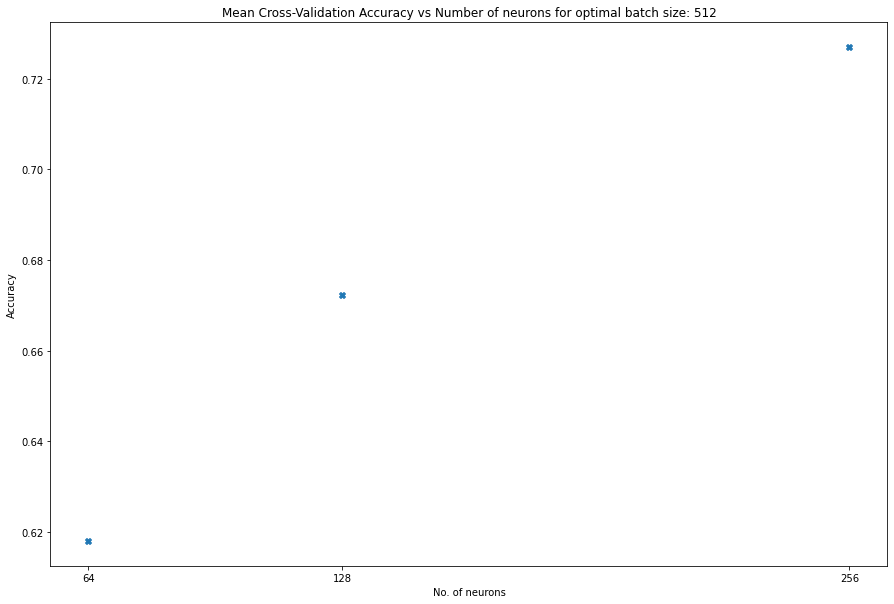

In [32]:
Q3_mean_val_acc = []
for key, value in Q3_model_acc.items():
    Q3_mean_val_acc.append(np.mean(value))

Q3_mean_val_loss = []
for key, value in Q3_model_loss.items():
    Q3_mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_val_acc, marker = 'X')
plt.title('Mean Cross-Validation Accuracy vs Number of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('No. of neurons')
plt.xticks(num_neurons_list)
plt.show()

In [33]:
for key, value in Q3_time_taken_dict.items():
    print(key, value)

model_neurons_64 [0.9606516361236572, 0.8689899444580078, 0.9039301872253418, 0.8830685615539551, 1.2502915859222412]
model_neurons_128 [0.908682107925415, 1.0094952583312988, 0.9131700992584229, 0.8547329902648926, 1.2019524574279785]
model_neurons_256 [0.918442964553833, 0.8828582763671875, 0.9394588470458984, 0.9167490005493164, 0.9523203372955322]


In [34]:
Q3_mean_time_taken = []
for key, value in Q3_time_taken_dict.items():
    Q3_mean_time_taken.append(np.mean(value))

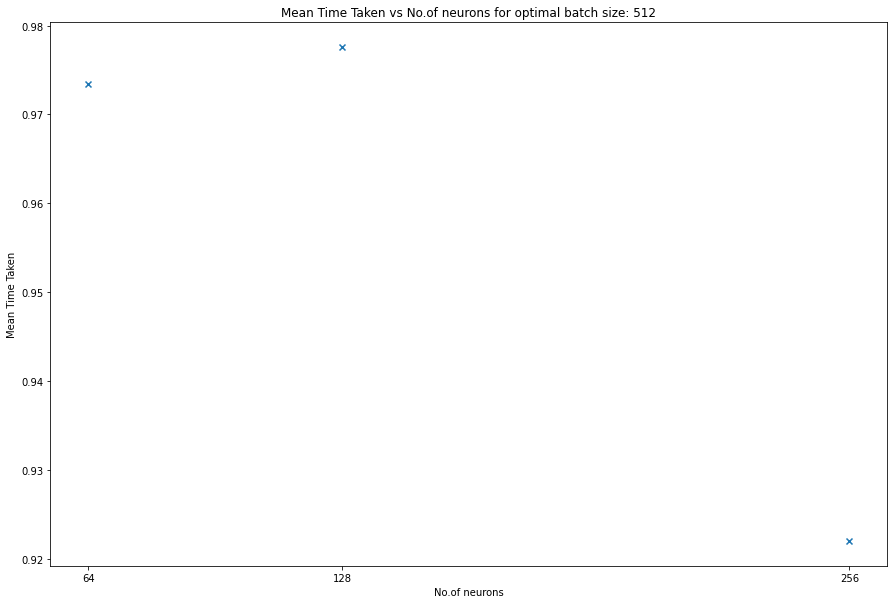

In [35]:
plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_time_taken, marker = 'x')
     
plt.title('Mean Time Taken vs No.of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Mean Time Taken')
plt.xlabel('No.of neurons')
plt.xticks(num_neurons_list)
plt.show()

In [36]:
Q3_table_df = pd.DataFrame.from_dict(Q3_model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
Q3_table_df["mean_val_acc"] = Q3_mean_val_acc
Q3_table_df["mean_val_loss"] = Q3_mean_val_loss
Q3_table_df["mean_time_taken"] = Q3_mean_time_taken
Q3_table_df["No. of neurons"] = num_neurons_list
Q3_table_df.set_index('No. of neurons', inplace = True)
Q3_table_df.head()

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_val_acc,mean_val_loss,mean_time_taken
No. of neurons,,,,,,,,
64,0.608900,0.615895,0.612055,0.628350,0.624938,0.618028,0.645746,0.973386
128,0.673699,0.674001,0.669117,0.677512,0.667682,0.672402,0.595189,0.977607
256,0.729994,0.733423,0.721325,0.728485,0.721975,0.727040,0.525607,0.921966


In [37]:
optimal_no_neurons = int(Q3_table_df['mean_val_acc'].idxmax())
print("Optimal number of neurons: {}".format(optimal_no_neurons))
print("Optimal batch size: {}".format(optimal_batch_size))

Optimal number of neurons: 256
Optimal batch size: 512


Q3d) How does dropout works, and what is the purpose of dropouts

Dropout is a technique where randomly selected neurons are ignored during training to avoid overfitting. Dropout prevents all neurons in a layer from syncrhonously optimizing their weights. It precents all the neurons from converging to the same goal, thus decorrelating the weights. As such, it increases the robustness of the model and reomves the simple dependencies between the neurons.



Q3e) Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach

Weight regularization. Weight regularization ensures that the weights of the network as large network weights indicates that the model is overfitting. The learning algorithm would encourage the network towards using small weights by penalizing the model with a larger loss score.

In [38]:
#Implementation of weight regularization with optimal batch and number of neurons
from tensorflow.keras import regularizers

optimized_model = Sequential([Dense(optimal_no_neurons, activation='relu', kernel_regularizer =regularizers.L1L2(0.000001,0.000001)),
                        Dropout(0.2), Dense(optimal_no_neurons, activation ='relu', kernel_regularizer =regularizers.L1L2(0.000001,0.000001)),
                        Dropout(0.2), Dense(optimal_no_neurons, activation='relu', kernel_regularizer =regularizers.L1L2(0.000001, 0.000001)),
                        Dropout(0.2), Dense(1, activation='sigmoid')])

#default values for l1 and l2 are 0.01

optimized_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [39]:
Q4_history = {}
Q4_history['optimized_model'] = optimized_model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 1,
                            batch_size = optimal_batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
250/250 [==============================] - 2s 7ms/step - loss: 0.6979 - accuracy: 0.5413 - val_loss: 0.6922 - val_accuracy: 0.5537
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.5592 - val_loss: 0.6885 - val_accuracy: 0.5611
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6857 - accuracy: 0.5680 - val_loss: 0.6852 - val_accuracy: 0.5699
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6808 - accuracy: 0.5750 - val_loss: 0.6793 - val_accuracy: 0.5777
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6748 - accuracy: 0.5862 - val_loss: 0.6739 - val_accuracy: 0.5900
Epoch 6/100
250/250 [==============================] - 1s 6ms/step - loss: 0.6684 - accuracy: 0.5953 - val_loss: 0.6692 - val_accuracy: 0.5961
Epoch 7/100
250/250 [==============================] - 2s 7ms/step - loss: 0.6620 - accuracy: 0.6081 - val_loss: 0.6614 - val_accuracy: 0.6117

In [40]:
Q4_train_loss, Q4_train_acc = optimized_model.evaluate(X_train_scaled, y_train, verbose = 0)
Q4_test_loss, Q4_test_acc = optimized_model.evaluate(X_test_scaled, y_test, verbose = 0)

print("Train loss: {}, Train accuracy: {}".format(Q4_train_loss, Q4_train_acc))
print("Test loss: {}, Test accuracy: {}".format(Q4_test_loss, Q4_test_acc))

Train loss: 0.4000648856163025, Train accuracy: 0.8517757654190063
Test loss: 0.5599122047424316, Test accuracy: 0.7129688858985901


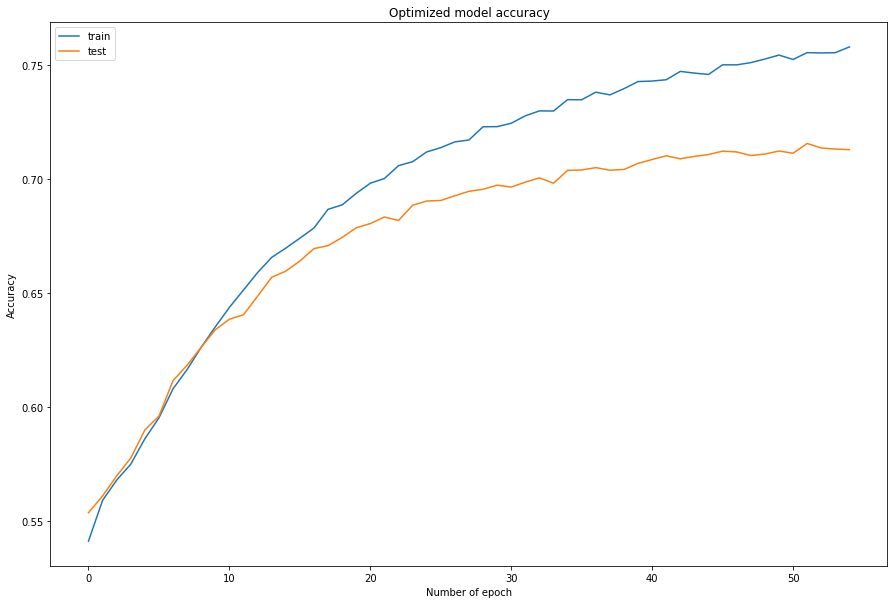

In [41]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q4_history['optimized_model'].history['accuracy'])
plt.plot(Q4_history['optimized_model'].history['val_accuracy'])
plt.title('Optimized model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

Q4

In [42]:

neg_voice_record_df = pd.read_csv('Q4_neg_voice_record.csv')
pos_voice_record_df = pd.read_csv('Q4_pos_voice_record.csv')
threshold = 0.5


In [43]:
neg_voice_record_df = neg_voice_record_df.drop(["filename"],axis = 1)
pos_voice_record_df = pos_voice_record_df.drop(["filename"], axis=1)



In [44]:
def process_dataset(df_train, df_test):
    
  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_test_scaled


neg_voice_record_df_scaled = process_dataset(X_train, neg_voice_record_df)
pos_voice_record_df_scaled = process_dataset(X_train, pos_voice_record_df)

In [45]:

neg_result_label = (optimized_model.predict(neg_voice_record_df_scaled)>threshold).astype("int32")


print(neg_result_label)

1/1 [==============================] - 0s 88ms/step
[[1]]


In [46]:
pos_result_label = (optimized_model.predict(pos_voice_record_df_scaled)>threshold).astype("int32")

print(pos_result_label)

1/1 [==============================] - 0s 17ms/step
[[1]]


In [47]:
#import tqdm as notebook_tqdm

# explainer = shap.DeepExplainer(optimized_model, X_train_scaled)
# shap_values = explainer.shap_values(X_test_scaled)
# shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_test.columns)